# Explore models
We explored 4 models:
1. ResNet50
2. Nose-Blocked + Edge Channel Enhanced Model
3. Dual-branch architecture with leg attention
4. Advanced Dual-Branch Architecture: 4-Channel Edge-Enhanced Input with Robust Regularization

## 1. ResNet50

In [ ]:
import os
import time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
import os
import time

In [13]:
# ----------------------
# 1. Dataset Definition
# ----------------------
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.image_names = [f.split('.')[0]
                             for f in os.listdir(self.image_dir)
                             if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, name + '.jpg')
        lbl_path = os.path.join(self.label_dir, name + '.txt')

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(lbl_path, 'r') as f:
            label = int(f.read().strip())

        return image, label

# ----------------------
# 2. Transforms: 224×224 + Normalize
# ----------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# ----------------------
# 3. Datasets & Loaders
# ----------------------
train_ds = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Train", transform)
val_ds = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Valid", transform)

train_loader = DataLoader(
    train_ds, batch_size=32, shuffle=True,
    num_workers=0 
)
val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False,
    num_workers=0
)

# ----------------------
# 4. Model: ResNet50 + Freeze + Replace Head
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# ----------------------
# 5. Loss & Optimization
# ----------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# ----------------------
# 6. Training & Validation Loop (with timing and checkpoints)
# ----------------------
num_epochs = 5
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print("=== Start training ===")
for epoch in range(1, num_epochs+1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")
    epoch_start = time.time()

    # Training phase
    model.train()
    train_preds, train_labels = [], []
    print("Entering training loop...")
    batch_count = 0
    for imgs, labels in train_loader:
        batch_count += 1
        if batch_count == 1:
            print("Loaded first training batch, starting backward pass...")
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_labels += labels.cpu().tolist()
    print(f"Finished {batch_count} training batches.")

    train_acc = accuracy_score(train_labels, train_preds)

    # Validation phase
    model.eval()
    val_preds, val_labels = [], []
    print("Entering validation loop...")
    vbatch_count = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            vbatch_count += 1
            if vbatch_count == 1:
                print("Loaded first validation batch, starting inference...")
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_labels += labels.cpu().tolist()
    print(f"Finished {vbatch_count} validation batches.")

    val_acc = accuracy_score(val_labels, val_preds)

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}/{num_epochs} done in {epoch_time:.1f}s | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Save checkpoint
    ckpt_path = os.path.join(checkpoint_dir, f"resnet50_epoch{epoch}.pt")
    torch.save(model.state_dict(), ckpt_path)
    print(f"Saved checkpoint: {ckpt_path}")

d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=== Start training ===

--- Epoch 1/5 ---
Entering training loop...
Loaded first training batch, starting backward pass...
Finished 11 training batches.
Entering validation loop...
Loaded first validation batch, starting inference...
Finished 4 validation batches.
Epoch 1/5 done in 40.3s | Train Acc: 0.8285 | Val Acc: 0.9300
  Saved checkpoint: checkpoints\resnet50_epoch1.pt

--- Epoch 2/5 ---
Entering training loop...
Loaded first training batch, starting backward pass...
Finished 11 training batches.
Entering validation loop...
Loaded first validation batch, starting inference...
Finished 4 validation batches.
Epoch 2/5 done in 37.8s | Train Acc: 0.9564 | Val Acc: 0.9400
  Saved checkpoint: checkpoints\resnet50_epoch2.pt

--- Epoch 3/5 ---
Entering training loop...
Loaded first training batch, starting backward pass...
Finished 11 training batches.
Entering validation loop...
Loaded first validation batch, starting inference...
Finished 4 validation batches.
Epoch 3/5 done in 64.4s |

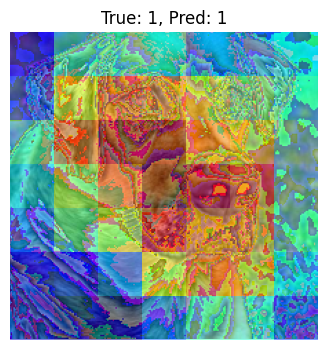

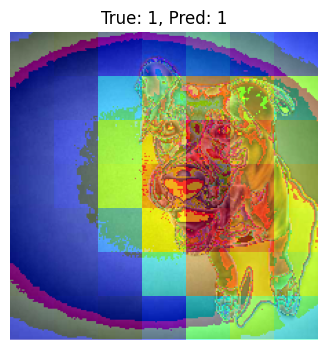

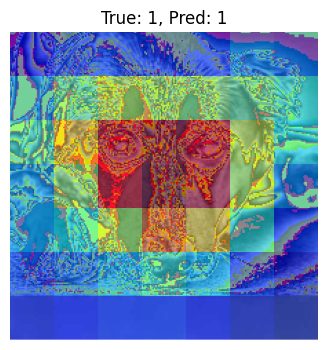

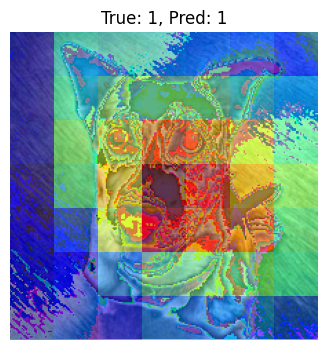

In [ ]:
# Specify the convolutional layer to use
cam_extractor = SmoothGradCAMpp(model, target_layer="layer4")

model.eval()
for imgs, labels in val_loader:
    imgs = imgs.to(device)
    for i in range(min(4, imgs.size(0))):
        inp = imgs[i].unsqueeze(0)
        inp.requires_grad_()
        
        # Forward + backward pass
        scores = model(inp)
        class_idx = scores.argmax(dim=1).item()
        scores[0, class_idx].backward()
        
        # Extract CAM (dictionary or list)
        cams = cam_extractor(class_idx, scores)
        
        heatmap = cams[0].squeeze().cpu().numpy()  # Ensure it's 2D H×W
        
        # Original image
        img = to_pil_image(inp.squeeze(0).cpu())
        
        # Overlay using Matplotlib
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.imshow(heatmap, cmap="jet", alpha=0.5, extent=(0, img.size[0], img.size[1], 0))
        plt.title(f"True: {labels[i].item()}, Pred: {class_idx}")
        plt.axis("off")
    break

### Try on 2000 random data from full dataset

In [17]:
# 1. Dataset Definition
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.image_names = [f.split('.')[0]
                             for f in os.listdir(self.image_dir)
                             if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, name + '.jpg')
        lbl_path = os.path.join(self.label_dir, name + '.txt')

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(lbl_path, 'r') as f:
            label = int(f.read().strip())

        return image, label

# 2. Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# 3. DataLoaders (example using cutted dataset)
train_ds = DogVsAiDataset(temp_train, transform)
val_ds   = DogVsAiDataset(temp_val,   transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# 4. Model Construction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# 5. Loss and Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# 6. Training Loop (with time tracking and checkpoints)
num_epochs = 5
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

print("=== Start training ===")
for epoch in range(1, num_epochs+1):
    print(f"\n--- Epoch {epoch}/{num_epochs} ---")
    t0 = time.time()
    
    # Training
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    
    # Validation
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    
    dt = time.time() - t0
    print(f"Epoch {epoch} done in {dt:.1f}s | Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"resnet50_epoch{epoch}.pt"))

=== Start training ===

--- Epoch 1/5 ---
Epoch 1 done in 397.7s | Train Acc 0.8700 | Val Acc 0.9380

--- Epoch 2/5 ---
Epoch 2 done in 445.9s | Train Acc 0.9435 | Val Acc 0.9500

--- Epoch 3/5 ---
Epoch 3 done in 464.4s | Train Acc 0.9475 | Val Acc 0.9360

--- Epoch 4/5 ---
Epoch 4 done in 306.6s | Train Acc 0.9490 | Val Acc 0.9520

--- Epoch 5/5 ---
Epoch 5 done in 237.6s | Train Acc 0.9630 | Val Acc 0.9520


In [ ]:
# Pure forward pass: collect validation set predictions
records = []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1)
        for i in range(imgs.size(0)):
            records.append((imgs[i].cpu(), labels[i].item(), preds[i].item()))

d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


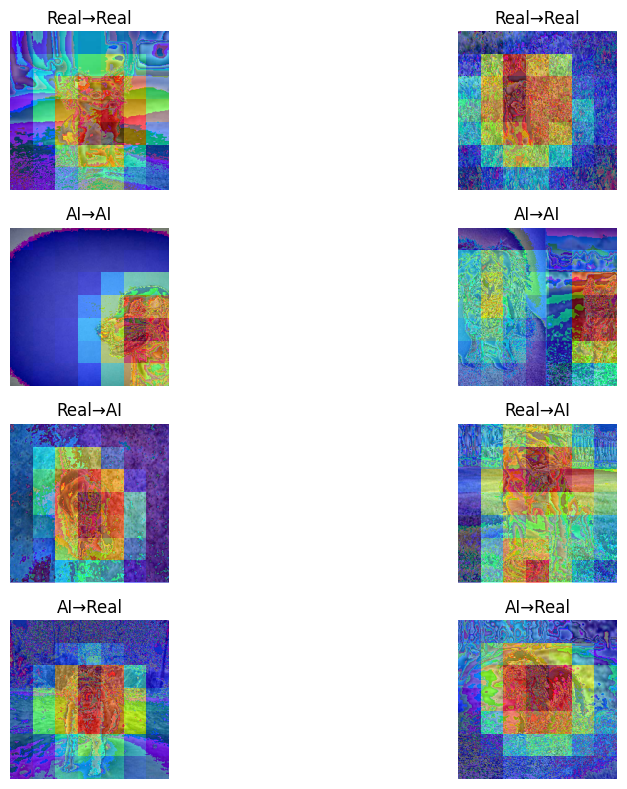

In [19]:
# Reload model to ensure no residual hooks
cam_model = models.resnet50(pretrained=True)
cam_model.fc = torch.nn.Linear(cam_model.fc.in_features, 2)
cam_model.load_state_dict(model.state_dict())
cam_model = cam_model.to(device).eval()

cam_extractor = SmoothGradCAMpp(cam_model, target_layer="layer4")

# Select two samples from each of the four categories
wanted = {(0,0):2, (1,1):2, (0,1):2, (1,0):2}
sample_idxs = {k:[] for k in wanted}
for idx, (_, t, p) in enumerate(records):
    if (t,p) in wanted and len(sample_idxs[(t,p)])<2:
        sample_idxs[(t,p)].append(idx)
    if all(len(v)==2 for v in sample_idxs.values()):
        break

# Rendering function
def render_cam(img_t, t, p):
    inp = img_t.unsqueeze(0).to(device).requires_grad_()
    scores = cam_model(inp)
    cls = scores.argmax(dim=1).item()
    scores[0,cls].backward()
    cams = cam_extractor(cls, scores)
    hm = cams[0].squeeze().cpu().numpy()
    hm = (hm - hm.min())/(hm.max()-hm.min())
    img = to_pil_image(img_t)
    plt.imshow(img)
    plt.imshow(hm, cmap="jet", alpha=0.5,
               extent=(0,img.size[0],img.size[1],0))
    plt.title(f"{t}→{p}")
    plt.axis("off")

# Display 4×2 grid
plt.figure(figsize=(12,8))
keys   = [(0,0),(1,1),(0,1),(1,0)]
titles = ["Real→Real","AI→AI","Real→AI","AI→Real"]
for r, key in enumerate(keys):
    for c, idx in enumerate(sample_idxs[key]):
        plt.subplot(4,2,r*2+c+1)
        img_t, t, p = records[idx]
        render_cam(img_t, t, p)
        plt.title(titles[r])
plt.tight_layout()
plt.show()

## 2. Nose-Blocked + Edge Channel Enhanced Model

In [ ]:
# 1. Environment Setup
import os, time, cv2, numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import accuracy_score

# Grad-CAM
from torchcam.methods import SmoothGradCAMpp

In [ ]:
# 2.1. Random Nose Masking (Erasing)
class RandomEraseNose:
    def __call__(self, img):
        w, h = img.size
        # Assume nose is in center-bottom area
        box = (int(w*0.4), int(h*0.5), int(w*0.6), int(h*0.7))
        draw = ImageDraw.Draw(img)
        draw.rectangle(box, fill=(0,0,0))
        return img

# 2.2. Add Edge Channel
class AddEdgeChannel:
    def __call__(self, img):
        # Convert to numpy BGR
        arr = np.array(img)[:,:,::-1]
        gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray,100,200)
        edges = Image.fromarray(edges).convert("L")
        # RGBA: use edges as 4th channel
        r,g,b = img.split()
        return Image.merge("RGBA", (r,g,b,edges))

# 2.3. Dataset Definition (4-channel support + RandomEraseNose + Edge)
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.names = [f.split('.')[0]
                       for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(os.path.join(self.image_dir, name + '.jpg')).convert("RGB")
        if self.transform:
            img = self.transform(img)  # PIL to 4-channel
        with open(os.path.join(self.label_dir, name + '.txt')) as f:
            lbl = int(f.read().strip())
        return img, lbl

In [ ]:
import random

def make_subset_dataset(root_dir, n_samples, seed=42):
    """
    Randomly sample n_samples images from root_dir/Images, return a new temporary directory temp_{n_samples},
    containing only Images and Labels subfolders, each with only these n_samples samples (soft links or copies).
    """
    random.seed(seed)
    img_dir = os.path.join(root_dir, "Images")
    lbl_dir = os.path.join(root_dir, "Labels")
    all_names = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
    sampled = random.sample(all_names, n_samples)
    
    temp_root = f"temp_{n_samples}"
    os.makedirs(os.path.join(temp_root, "Images"), exist_ok=True)
    os.makedirs(os.path.join(temp_root, "Labels"), exist_ok=True)
    
    for name in sampled:
        base = name.split(".")[0]
        # Can use copy or soft link, using copy below
        src_img = os.path.join(img_dir, name)
        dst_img = os.path.join(temp_root, "Images", name)
        src_lbl = os.path.join(lbl_dir, base + ".txt")
        dst_lbl = os.path.join(temp_root, "Labels", base + ".txt")
        # Copy
        import shutil
        shutil.copy(src_img, dst_img)
        shutil.copy(src_lbl, dst_lbl)
    
    return temp_root

# Sample 2000 images from full train set
temp_train = make_subset_dataset(
    "archive/Dogs Vs AiDogs/Train", n_samples=2000, seed=123
)
temp_val   = make_subset_dataset(
    "archive/Dogs Vs AiDogs/Valid", n_samples= 500, seed=456
)

In [ ]:
# 3. Transforms: 224×224, Pipeline: Nose Masking → Edge Channel → ToTensor → Normalize
transform = transforms.Compose([
    transforms.Resize((224,224)),
    RandomEraseNose(),
    AddEdgeChannel(),        # Generate RGBA
    transforms.ToTensor(),   # 4×224×224
    transforms.Normalize(
        mean=[0.485,0.456,0.406,0.5],   # 4th channel mean 0.5
        std =[0.229,0.224,0.225,0.5]    # 4th channel std 0.5
    )
])

# Original transform remains unchanged
train_ds = DogVsAiDataset(temp_train, transform)
val_ds   = DogVsAiDataset(temp_val,   transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

In [5]:
# 4. Build ResNet50 (4-channel input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load from torchvision, modify first conv layer to accept 4 channels
model = models.resnet50(pretrained=True)
orig = model.conv1
model.conv1 = nn.Conv2d(
    4, orig.out_channels,
    kernel_size=orig.kernel_size,
    stride=orig.stride,
    padding=orig.padding,
    bias=orig.bias is not None
)
# Copy original weights to first 3 channels of new conv
model.conv1.weight.data[:,:3] = orig.weight.data
model.conv1.weight.data[:,3]  = orig.weight.data[:,0]  # Initialize 4th channel same as R

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False
# Classification head
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# 5. Loss and Optimization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Training loop
checkpoint_dir = "checkpoints_edge_nose"
os.makedirs(checkpoint_dir, exist_ok=True)
num_epochs = 5

print("=== Start training with nose‑erase & edge channel ===")
for ep in range(1, num_epochs+1):
    t0 = time.time()
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    
    print(f"Epoch {ep}/{num_epochs} done in {time.time()-t0:.1f}s | "
          f"Train Acc {train_acc:.4f} | Val Acc {val_acc:.4f}")
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"ep{ep}.pt"))

=== Start training with nose‑erase & edge channel ===
Epoch 1/5 done in 195.1s | Train Acc 0.8615 | Val Acc 0.9220
Epoch 2/5 done in 198.7s | Train Acc 0.9270 | Val Acc 0.9340
Epoch 3/5 done in 199.8s | Train Acc 0.9385 | Val Acc 0.9460
Epoch 4/5 done in 208.0s | Train Acc 0.9500 | Val Acc 0.9300
Epoch 5/5 done in 201.8s | Train Acc 0.9490 | Val Acc 0.9500


d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


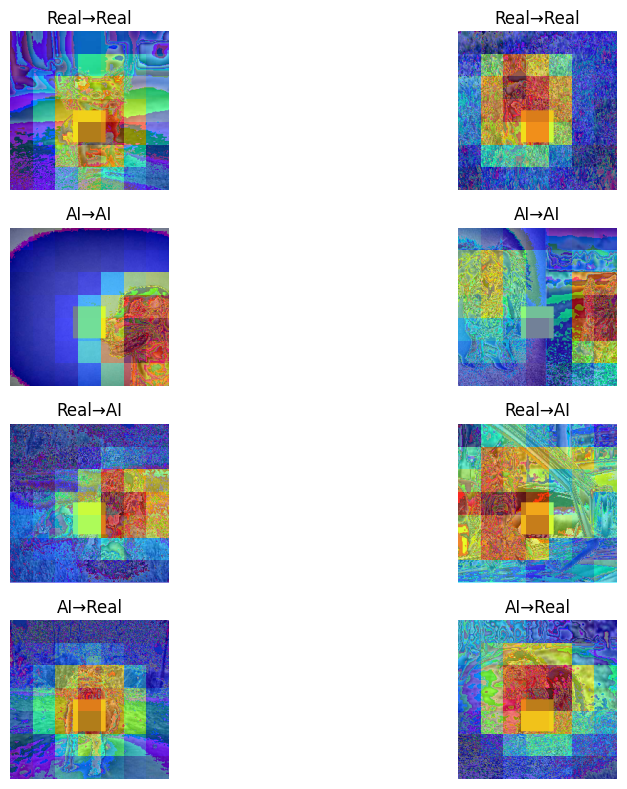

In [16]:
# 6. Grad-CAM Visualization: 4×2 grid, 2 samples per group
# Collect prediction records
records = []
model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        out = model(imgs)
        preds = out.argmax(dim=1)
        for i in range(imgs.size(0)):
            records.append((imgs[i].cpu(), labels[i].item(), preds[i].item()))

# Select 2 samples from each group
wanted = {(0,0):2,(1,1):2,(0,1):2,(1,0):2}
sample_idxs = {k:[] for k in wanted}
for idx,(img, t, p) in enumerate(records):
    if (t,p) in wanted and len(sample_idxs[(t,p)])<2:
        sample_idxs[(t,p)].append(idx)
    if all(len(v)==2 for v in sample_idxs.values()):
        break

# Reload model for CAM (no hook contamination)
cam_model = models.resnet50(pretrained=True)
# Same conv1 modification & fc replacement
cam_model.conv1 = model.conv1
cam_model.fc = nn.Linear(cam_model.fc.in_features, 2)
cam_model.load_state_dict(model.state_dict())
cam_model = cam_model.to(device).eval()

cam_extractor = SmoothGradCAMpp(cam_model, target_layer="layer4")

# Rendering function
def render_cam(img_t, t, p):
    inp = img_t.unsqueeze(0).to(device).requires_grad_()
    scores = cam_model(inp)
    cls = scores.argmax(dim=1).item()
    scores[0,cls].backward()
    cams = cam_extractor(cls, scores)
    hm = cams[0].squeeze().cpu().numpy()
    hm = (hm-hm.min())/(hm.max()-hm.min())
    img = to_pil_image(img_t[:3])  # Only take RGB first 3 channels
    plt.imshow(img)
    plt.imshow(hm, cmap="jet", alpha=0.5,
               extent=(0,img.size[0],img.size[1],0))
    plt.title(f"{t}→{p}")
    plt.axis("off")

# Draw 4×2 grid
plt.figure(figsize=(12,8))
keys   = [(0,0),(1,1),(0,1),(1,0)]
titles = ["Real→Real","AI→AI","Real→AI","AI→Real"]
for r,key in enumerate(keys):
    for c,idx in enumerate(sample_idxs[key]):
        plt.subplot(4,2,r*2+c+1)
        img_t,t,p = records[idx]
        render_cam(img_t, t, p)
        plt.title(titles[r])
plt.tight_layout()
plt.show()

## 3. Dual-branch architecture with leg attention

In [15]:
import os, time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score

# ----------------------
# 1. Dataset (same as before, only outputs 3-channel full image Tensor)
# ----------------------
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.names = [f.split('.')[0] 
                      for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.names)
    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(os.path.join(self.image_dir, name+".jpg")).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = int(open(os.path.join(self.label_dir, name+".txt")).read().strip())
        return img, lbl

# ----------------------
# 2. Transforms
# ----------------------
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
      mean=[0.485,0.456,0.406],
      std =[0.229,0.224,0.225]
    )
])

# ----------------------
# 3. DataLoaders (CUTTED random subset can also directly replace paths)
# ----------------------
train_ds = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Train", transform)
val_ds   = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Valid", transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# ----------------------
# 4. Dual-Branch Model Definition
# ----------------------
class DualBranchNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # Global branch backbone
        self.global_backbone = models.resnet50(pretrained=True)
        # Freeze half parameters to make training faster (optional)
        for p in list(self.global_backbone.parameters())[:-10]:
            p.requires_grad = False

        # Leg branch backbone (same structure, but shallower can use ResNet18)
        self.leg_backbone = models.resnet18(pretrained=True)
        for p in list(self.leg_backbone.parameters())[:-6]:
            p.requires_grad = False

        # Classification head: concat features from both branches then classify
        self.classifier = nn.Sequential(
            nn.Linear(self.global_backbone.fc.in_features 
                      + self.leg_backbone.fc.in_features, 256),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: [B,3,224,224]
        # —— Global features —— 
        g = self.global_backbone.conv1(x)
        g = self.global_backbone.bn1(g)
        g = self.global_backbone.relu(g)
        g = self.global_backbone.maxpool(g)
        g = self.global_backbone.layer1(g)
        g = self.global_backbone.layer2(g)
        g = self.global_backbone.layer3(g)
        g = self.global_backbone.layer4(g)
        g = self.global_backbone.avgpool(g)
        g = torch.flatten(g, 1)  # [B, global_dim]

        # —— Leg features —— Crop lower half from x
        B, C, H, W = x.shape
        # Take lower half approximately 50%~100% region
        leg_crop = x[:, :, int(H*0.5):, :]
        # Then resize back to 224×224
        leg_crop = torch.nn.functional.interpolate(leg_crop, size=(224,224))
        l = self.leg_backbone.conv1(leg_crop)
        l = self.leg_backbone.bn1(l)
        l = self.leg_backbone.relu(l)
        l = self.leg_backbone.maxpool(l)
        l = self.leg_backbone.layer1(l)
        l = self.leg_backbone.layer2(l)
        l = self.leg_backbone.layer3(l)
        l = self.leg_backbone.layer4(l)
        l = self.leg_backbone.avgpool(l)
        l = torch.flatten(l, 1)    # [B, leg_dim]

        # —— Concatenate & classify —— 
        f = torch.cat([g, l], dim=1)
        return self.classifier(f)

# ----------------------
# 5. Training & Validation Loop
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

num_epochs = 5
print("=== Start Dual-Branch Training ===")
for ep in range(1, num_epochs+1):
    t0 = time.time()
    # Training
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    # Validation
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    print(f"Epoch {ep}/{num_epochs} — "
          f"time {time.time()-t0:.1f}s  train_acc {train_acc:.4f}  val_acc {val_acc:.4f}")

d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\software\anaconda\envs\ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the

=== Start Dual‑Branch Training ===
Epoch 1/5 — time 105.1s  train_acc 0.8634  val_acc 0.9800
Epoch 2/5 — time 81.7s  train_acc 0.9855  val_acc 0.9700
Epoch 3/5 — time 88.9s  train_acc 1.0000  val_acc 0.9800
Epoch 4/5 — time 104.3s  train_acc 0.9971  val_acc 0.9800
Epoch 5/5 — time 100.6s  train_acc 1.0000  val_acc 0.9800


## 4. Advanced Dual-Branch Architecture: 4-Channel Edge-Enhanced Input with Robust Regularization

In [11]:
import os, time
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score

# ----------------------
# 1. Dataset (same as before, only outputs 3-channel full image Tensor)
# ----------------------
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.names = [f.split('.')[0] 
                      for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
    def __len__(self):
        return len(self.names)
    def __getitem__(self, idx):
        name = self.names[idx]
        img = Image.open(os.path.join(self.image_dir, name+".jpg")).convert("RGB")
        if self.transform: img = self.transform(img)
        lbl = int(open(os.path.join(self.label_dir, name+".txt")).read().strip())
        return img, lbl

# ----------------------
# 2. Transforms
# ----------------------
# —— Data augmentation & 4-channel transform —— 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    AddEdgeChannel(),    # RGBA
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406,0.5],
                         std =[0.229,0.224,0.225,0.5])
])

# ----------------------
# 3. DataLoaders (CUTTED random subset can also directly replace paths)
# ----------------------
# train_ds = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Train", transform)
# val_ds   = DogVsAiDataset("archive/Dogs Vs AiDogs_CUTTED/Valid", transform)
train_ds = DogVsAiDataset(temp_train, transform)
val_ds   = DogVsAiDataset(temp_val,   transform)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

# ----------------------
# 4. Dual-Branch Model Definition
# ----------------------
class DualBranchNet(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        # —— Global branch backbone —— 
        self.global_backbone = models.resnet50(pretrained=True)
        orig1 = self.global_backbone.conv1
        self.global_backbone.conv1 = nn.Conv2d(
            4, orig1.out_channels,
            kernel_size=orig1.kernel_size,
            stride=orig1.stride,
            padding=orig1.padding,
            bias=(orig1.bias is not None)
        )
        with torch.no_grad():
            # First 3 channels use pretrained weights, 4th channel copies 1st channel
            self.global_backbone.conv1.weight[:, :3] = orig1.weight
            self.global_backbone.conv1.weight[:, 3:4] = orig1.weight[:, :1]

        # —— Leg branch backbone —— 
        self.leg_backbone = models.resnet18(pretrained=True)
        orig2 = self.leg_backbone.conv1
        self.leg_backbone.conv1 = nn.Conv2d(
            4, orig2.out_channels,
            kernel_size=orig2.kernel_size,
            stride=orig2.stride,
            padding=orig2.padding,
            bias=(orig2.bias is not None)
        )
        with torch.no_grad():
            self.leg_backbone.conv1.weight[:, :3] = orig2.weight
            self.leg_backbone.conv1.weight[:, 3:4] = orig2.weight[:, :1]

        # —— Classification head: concat features from both branches then classify —— 
        dim_g = self.global_backbone.fc.in_features
        dim_l = self.leg_backbone.fc.in_features
        self.classifier = nn.Sequential(
            nn.Linear(dim_g + dim_l, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: [B,4,224,224] (R,G,B,Edge)
        # —— Global branch —— 
        g = self.global_backbone.conv1(x)
        g = self.global_backbone.bn1(g)
        g = self.global_backbone.relu(g)
        g = self.global_backbone.maxpool(g)
        g = self.global_backbone.layer1(g)
        g = self.global_backbone.layer2(g)
        g = self.global_backbone.layer3(g)
        g = self.global_backbone.layer4(g)
        g = self.global_backbone.avgpool(g)
        g = torch.flatten(g, 1)

        # —— Leg branch —— Crop lower half then resize —— 
        B, C, H, W = x.shape
        leg = x[:, :, int(H*0.5):, :]                          # [B,4,H/2,W]
        leg = nn.functional.interpolate(leg, size=(224,224))    # [B,4,224,224]
        l = self.leg_backbone.conv1(leg)
        l = self.leg_backbone.bn1(l)
        l = self.leg_backbone.relu(l)
        l = self.leg_backbone.maxpool(l)
        l = self.leg_backbone.layer1(l)
        l = self.leg_backbone.layer2(l)
        l = self.leg_backbone.layer3(l)
        l = self.leg_backbone.layer4(l)
        l = self.leg_backbone.avgpool(l)
        l = torch.flatten(l, 1)

        # —— Concatenate & classify —— 
        f = torch.cat([g, l], dim=1)
        return self.classifier(f)

# ----------------------
# 5. Training & Validation Loop
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualBranchNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3, weight_decay=1e-4
)

num_epochs = 5
print("=== Start Dual-Branch Training ===")
for ep in range(1, num_epochs+1):
    t0 = time.time()
    # Training
    model.train()
    tp, tl = [], []
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        tp += out.argmax(1).cpu().tolist()
        tl += labels.cpu().tolist()
    train_acc = accuracy_score(tl, tp)
    # Validation
    model.eval()
    vp, vl = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            vp += out.argmax(1).cpu().tolist()
            vl += labels.cpu().tolist()
    val_acc = accuracy_score(vl, vp)
    print(f"Epoch {ep}/{num_epochs} — "
          f"time {time.time()-t0:.1f}s  train_acc {train_acc:.4f}  val_acc {val_acc:.4f}")

=== Start Dual‑Branch Training ===
Epoch 1/5 — time 375.8s  train_acc 0.7970  val_acc 0.7340
Epoch 2/5 — time 389.8s  train_acc 0.8670  val_acc 0.5920
Epoch 3/5 — time 528.3s  train_acc 0.8850  val_acc 0.7100
Epoch 4/5 — time 475.5s  train_acc 0.8980  val_acc 0.8240
Epoch 5/5 — time 372.5s  train_acc 0.9000  val_acc 0.8660
